In [10]:
import configparser
import pandas as pd
import numpy as np
import tiktoken
import ast
import openai
import matplotlib
import matplotlib.pylab as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from openai.embeddings_utils import get_embedding

config = configparser.ConfigParser()
config.read('../config.ini')
openai.api_key = config.get('Openai', 'api_key')


In [21]:
# 加载数据集

files_path="../datas/fine_food_reviews_3.csv"
df = pd.read_csv(files_path,index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df

,Time,ProductId,UserId,Score,Summary,Text
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos..."
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...


In [22]:
df["combined"]=("Title："+df.Summary.str.strip()+"content："+df.Text.str.strip())
df

,Time,ProductId,UserId,Score,Summary,Text,combined
0,1351123200,B003XPF9BO,A3R7JR3FMEBXQB,5,where does one start...and stop... with a tre...,Wanted to save some to bring to my Chicago fam...,Title：where does one start...and stop... with...
1,1351123200,B003JK537S,A3JBPC3WFUT5ZP,1,Arrived in pieces,"Not pleased at all. When I opened the box, mos...",Title：Arrived in piecescontent：Not pleased at ...
2,1351123200,B000JMBE7M,AQX1N6A51QOKG,4,"It isn't blanc mange, but isn't bad . . .",I'm not sure that custard is really custard wi...,"Title：It isn't blanc mange, but isn't bad . . ..."


In [23]:
df["combined"]

0    Title：where does one  start...and stop... with...
1    Title：Arrived in piecescontent：Not pleased at ...
2    Title：It isn't blanc mange, but isn't bad . . ...
Name: combined, dtype: object

In [24]:
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"
max_tokens = 8000  

In [28]:
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
output_datapath = "../datas/fine_food_reviews_with_embeddings_3.csv"

df.to_csv(output_datapath)

RetryError: RetryError[<Future at 0x2a15d2bf0 state=finished raised AuthenticationError>]

In [2]:
files_path="../datas/fine_food_reviews_with_embeddings_1k.csv"
df_embeded = pd.read_csv(files_path,index_col=0)

# 将字符串转换为向量
df_embeded["embedding_vec"] = df_embeded["embedding"].apply(ast.literal_eval)

In [3]:
type(df_embeded["embedding_vec"])

pandas.core.series.Series

In [4]:
assert df_embeded['embedding_vec'].apply(len).nunique() == 1

In [5]:
matrix = np.vstack(df_embeded['embedding_vec'].values)

In [6]:
matrix.shape

(1000, 1536)

In [7]:
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)

In [8]:
vis_dims = tsne.fit_transform(matrix)

In [35]:
vis_dims.shape

(1000, 2)

In [9]:
colors = ["red", "darkorange", "gold", "turquoise", "darkgreen"]
# colors = ["red", "orange", "green", "yellow", "blue"]

In [10]:
# 从降维后的坐标中分别获取所有数据点的横坐标和纵坐标
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

# 根据数据点的评分（减1是因为评分是从1开始的，而颜色索引是从0开始的）获取对应的颜色索引
color_indices = df_embeded.Score.values - 1

# 确保你的数据点和颜色索引的数量匹配
assert len(vis_dims) == len(df_embeded.Score.values)

[Text(1, 0, 'red - Score:1'),
 Text(1, 1, 'darkorange - Score:2'),
 Text(1, 2, 'gold - Score:3'),
 Text(1, 3, 'turquoise - Score:4'),
 Text(1, 4, 'darkgreen - Score:5')]

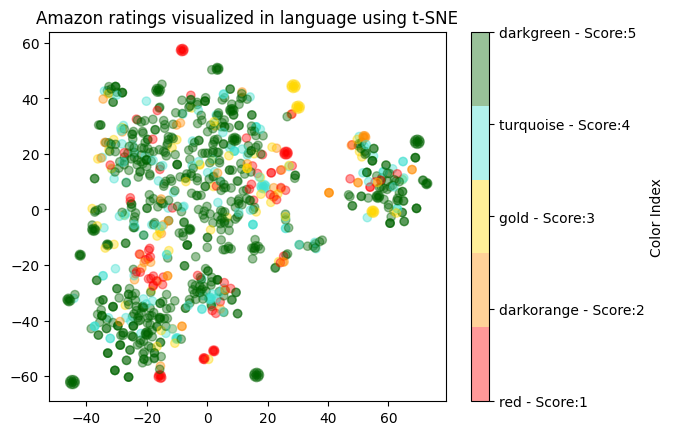

In [11]:
# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)
# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定，alpha 是点的透明度
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.4)

# 为图形添加标题
plt.title("Amazon ratings visualized in language using t-SNE")

# 添加颜色指标对应关系
color_labels = ["red - Score:1", "darkorange - Score:2", "gold - Score:3", "turquoise - Score:4", "darkgreen - Score:5"]
plt.colorbar(ticks=range(len(color_labels)), label="Color Index").ax.set_yticklabels(color_labels)

In [60]:
# t-SNE降维后，产生了大约3个大类，其中1个大类的评论大多是负面的。即：red - Score:1
4. 使用 K-Means 聚类，然后使用 t-SNE 可视化

In [12]:
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df_embeded['Cluster'] = kmeans.labels_


/Users/yangshengqin/my_pyenv/AINote/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [97]:
df_embeded['Cluster']

0      3
297    2
296    3
295    0
294    3
      ..
623    2
624    0
625    1
619    2
999    2
Name: Cluster, Length: 1000, dtype: int32

In [13]:
colors = ["red", "green", "blue", "purple"]
tsne_model = TSNE(n_components=2, random_state=42)
vis_data = tsne_model.fit_transform(matrix)
# 现在，你可以从降维后的数据中获取 x 和 y 坐标。
x = vis_data[:, 0]
y = vis_data[:, 1]

In [14]:
vis_data

array([[-14.908672 ,  -5.2879043],
       [ 62.788567 ,  -8.416785 ],
       [-49.051147 , -23.330372 ],
       ...,
       [-57.592953 ,  27.411818 ],
       [ 41.481106 , -35.538548 ],
       [ 46.11965  , -24.180891 ]], dtype=float32)

In [15]:
x

array([-1.49086723e+01,  6.27885666e+01, -4.90511475e+01,  1.19825420e+01,
       -4.90511475e+01, -3.62225113e+01, -1.05978785e+01, -4.24730825e+00,
       -3.42458992e+01, -2.11725159e+01,  5.67579880e+01, -5.66405296e+01,
        1.30349684e+01,  1.50444150e+00, -7.37280416e+00,  9.28513241e+00,
        1.59668732e+01, -6.92084274e+01, -6.77980957e+01, -6.92758026e+01,
        5.00264359e+01, -5.48845100e+01, -6.95153351e+01, -6.60347900e+01,
        4.22137642e+01, -4.90511475e+01,  1.18410378e+01,  3.29796257e+01,
        4.41060400e+00,  9.93304774e-02, -2.43532963e+01, -3.79982147e+01,
        3.83688354e+01, -8.78906727e+00, -2.76157742e+01, -2.83094063e+01,
       -8.60583687e+00, -5.94435263e+00,  4.32695150e+00,  3.05683765e+01,
       -4.51535912e+01, -3.61538672e+00, -5.48152733e+01, -1.62411270e+01,
       -2.85934010e+01,  1.45786037e+01,  3.27142754e+01,  2.49200535e+01,
       -8.14669132e+00,  4.06686592e+01,  3.17450047e+01, -5.31516838e+00,
       -6.40014343e+01, -

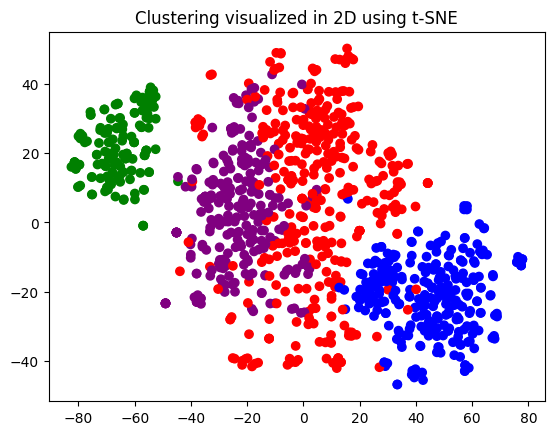

In [16]:
# 'Cluster' 列中的值将被用作颜色索引。
color_indices = df_embeded['Cluster'].values

# 创建一个基于预定义颜色的颜色映射对象
colormap = matplotlib.colors.ListedColormap(colors)

# 使用 matplotlib 创建散点图，其中颜色由颜色映射对象和颜色索引共同决定
plt.scatter(x, y, c=color_indices, cmap=colormap)

# 为图形添加标题
plt.title("Clustering visualized in 2D using t-SNE")

# 显示图形
plt.show()

In [ ]:
K-MEANS 聚类可视化效果，4类：一个专注于狗粮，一个专注于负面评论，两个专注于正面评论。

In [17]:
from openai.embeddings_utils import get_embedding, cosine_similarity

In [134]:
type(df_embeded["embedding_vec"][0])


list

In [18]:
# 定义一个名为 search_reviews 的函数，
# Pandas DataFrame 产品描述，数量，以及一个 pprint 标志（默认值为 True）。
def search_reviews(df, product_description, n=3, pprint=True):
    product_embedding = get_embedding(
        product_description,
        engine="text-embedding-ada-002"
    )
    df["similarity"] = df.embedding_vec.apply(lambda x: cosine_similarity(x, product_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
        .combined.str.replace("Title: ", "")
        .str.replace("; Content:", ": ")
    )
    if pprint:
        for r in results:
            print(r[:200])
            print()
    return results

In [19]:
# 使用 'delicious beans' 作为产品描述和 3 作为数量，
# 调用 search_reviews 函数来查找与给定产品描述最相似的前3条评论。
# 其结果被存储在 res 变量中。
res = search_reviews(df_embeded, 'delicious beans', n=3)

Good Buy:  I liked the beans. They were vacuum sealed, plump and moist. Would recommend them for any use. I personally split and stuck them in some vodka to make vanilla extract. Yum!

Jamaican Blue beans:  Excellent coffee bean for roasting. Our family just purchased another 5 pounds for more roasting. Plenty of flavor and mild on acidity when roasted to a dark brown bean and befor

Delicious!:  I enjoy this white beans seasoning, it gives a rich flavor to the beans I just love it, my mother in law didn't know about this Zatarain's brand and now she is traying different seasoning



In [137]:

# 选一条类别3的评论
df_embeded['combined'][0]


'Title: where does one  start...and stop... with a treat like this; Content: Wanted to save some to bring to my Chicago family but my North Carolina family ate all 4 boxes before I could pack. These are excellent...could serve to anyone'

In [139]:
res = search_reviews(df_embeded, df_embeded['combined'][0], n=1)

RetryError: RetryError[<Future at 0x2d6be41f0 state=finished raised AuthenticationError>]